# Example Jupyter Notebook for micropattern (MP) image analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from support_functions import *
from micropattern_analysis import *
import imageio.v3 as iio
import os

## Introduction to image analysis of MPs

In [2]:
img_file = r"C:\Users\flori\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images\all_fates_pax6_isi12_sox10\MP_ISTA_STAN_BMP4_800um_DAPI_pax6_555_sox10_647_isi12_488_2024_01_05__17_57_15.lsm"

image = iio.imread(img_file)

Here we can see that the images are stored as numpy arrays with multiple dimensions. Let's quickly break it down how the images are stored in a ```numpy``` matrix

In [3]:
print_image_dim_explanation()

(3, 4, 1024, 1024)
 |  |    |     |  
 |  |    +-----+-- X & Y 'coordinates' of image
 |  +------------- channels of image
 +---------------- z-stacks of image



As we can see, our image is a multichannel image with multiple z-stacks. Where the first axis (dimension) corresponds to each z-stack with its corresponding channels. The second axis describes the different channels found in the image. The last two axis are responsible for storage of the pixel values of each channel and corresponding z-stack.

Now, as we have seen our images contain z-stacks for which we are not interested in for our analysis. Therefore we can maximise the images to a single stack.

In [4]:
shape_old = image.shape
shape_new = maximise_and_normalize(image).shape
print(f'Original shape\tvs.\tnew shape')
print(f'{shape_old}\t->\t{shape_new}')

Original shape	vs.	new shape
(3, 4, 1024, 1024)	->	(4, 1024, 1024)


As we can see this effectively reduced one image dimension.

In [5]:
# TODO: continue with introductory notebook sections

## Streamlined image analysis through the usage of pipelines

First we have to select a directory from which the images should be accessed. Here we could first set the directory - where our images are located - to our current working directory. This gives us the opportunity to expect the subdirectories or files which we may want to include or exclude from our analysis.

In [6]:
dir = r"C:\Users\flori\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['ab testing', 'all_fates_neg_ctr', 'all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10', 'Lost and Found Florian']


Here the selected directory contains some subdirectories which we are not interested in including. Therefore we can select specifically which directories to include into the list of paths.

In [7]:
dirs = dirs[2:4]
print(dirs)

['all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10']


Much better! With this done we can start loading our images into the notebook. For this and further actions with first have to import the custom script for analysis.

In [ ]:
image_dict = get_files_and_images(dirs)

In [6]:
first_element_key = list(image_dict.keys())[0]
first_element_value = image_dict.get(first_element_key)
print(f'type of image_dict:\t{type(image_dict)}')
print(f'Number of images:\t{len(image_dict.keys())}')
print(f'First element of image_dict w/ values and types:')
print(f'\t"{first_element_key}"\t{type(first_element_key)}')
print(f'\t{first_element_value.shape}\t{type(first_element_value)}')

type of image_dict:	<class 'dict'>
Number of images:	42
First element of image_dict w/ values and types:
	"all_fates_pax6_isi12_sox10\MP_ISTA_STAN_BMP4_800um_DAPI_pax6_555_sox10_647_isi12_488_2024_01_05__17_57_15.lsm"	<class 'str'>
	(3, 4, 1024, 1024)	<class 'numpy.ndarray'>


As we can see the method ```get_files_and_images()``` returns a dictionary with the image file names as keys and the images as a values. As seen above we can maximise the images and normalize them in one go.

If you want to "untangle" the images from their file names then following line can accomplish this. 

In [ ]:
file_names, images = zip(*image_dict.items())

And if you want to skip the ```image_dict``` step altogether, then we can directly call the ```get_files_and_images()``` function.

In [8]:
file_names, images = zip(*get_files_and_images(dirs).items())

In [9]:
from toolz import pipe

v_new = list(map(lambda x:
                 pipe(x,
                      lambda f: maximise_and_normalize(f)
                      ),
                 images))

print(f'Original shape:\t{images[0].shape}')
print(f'New shape:\t{v_new[0].shape}')

Original shape:	(3, 4, 1024, 1024)
New shape:	(4, 1024, 1024)


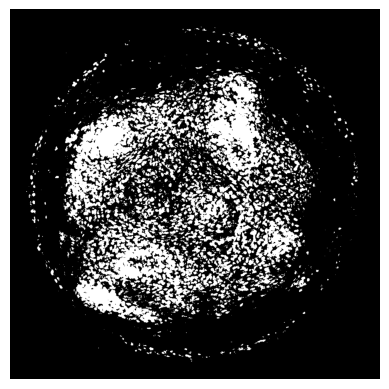

In [43]:
from skimage.filters import threshold_multiotsu

i1 = maximise_and_normalize(images[0])

plt.imshow(i1[3] > threshold_multiotsu(i1[3], classes=4)[1], cmap='gray')
plt.axis('off')
plt.show()

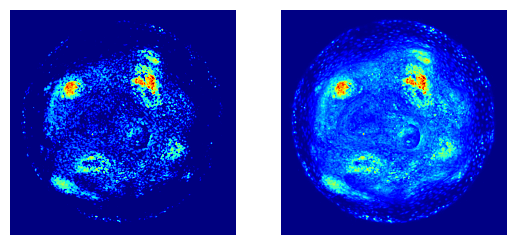

In [44]:
bob = i1 * (i1[3] > threshold_multiotsu(i1[3], classes=4)[1])

fig, (a, b) = plt.subplots(1,2)
a.imshow(bob[1], cmap="jet")
a.axis('off')
b.imshow(i1[1], cmap="jet")
b.axis('off')
plt.show()

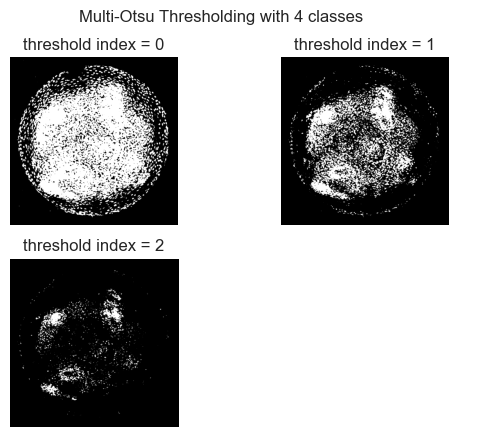

In [67]:
def create_dapi_img_mask_multiotsu(
        img,
        dapi_img_num,
        num_classes=4,
        threshold_index=1
):
    thresholds = threshold_multiotsu(img[dapi_img_num], classes=num_classes)
    dapi_threshold = thresholds[threshold_index]
    return img[dapi_img_num] > dapi_threshold

class_n = 4
square = class_n // 2 if class_n > 3 else class_n - 1
    
fig, axes = plt.subplots(square,square)
for i, ax in enumerate(axes.flat):
    if i < (class_n - 1):
        ax.imshow(create_dapi_img_mask_multiotsu(i1, 3, num_classes=class_n, threshold_index=i), cmap="gray")
        ax.set_title(f"threshold index = {i}")
    ax.axis('off')
fig.suptitle(f"Multi-Otsu Thresholding with {class_n} classes")
plt.show()